In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ['KMP_WARNINGS'] = 'off'
import sys
import git

import uproot as ut
import awkward as ak
import numpy as np
import math
import vector
import sympy as sp

import re
from tqdm import tqdm
import timeit
import re

sys.path.append( git.Repo('.', search_parent_directories=True).working_tree_dir )
from utils import *

In [91]:
kinematics = ['pt','eta','phi','mass']

def get_max_dr(parts):
    flat_dr = ak.flatten(parts.deltaR(parts[:,None]), axis=2)
    return ak.max(flat_dr, axis=1)

def plot_parts(parts):
    fig, axs = study.get_figax(5)

    nparts = ak.min(ak.num(parts))
    for i, kin in enumerate(kinematics):
        hist_multi([ getattr(parts, kin)[:, i] for i in range(nparts) ], ratio=True, figax=(fig, axs.flat[i]))
    max_dr = get_max_dr(parts)
    histo_array(max_dr, figax=(fig, axs.flat[4]))

    return max_dr

In [247]:
from utils.genprodUtils import two_body_decay
from utils.genprodUtils.generators import Generator

gen_info = dict(
    pt = lambda n : np.random.uniform(0, 5*10, size=n),
    eta = lambda n : np.zeros(n),
    phi = lambda n : np.zeros(n),
    mass = lambda n : 10 * np.ones(n),
)

gen = Generator( gen_info )
N = 100000
event = gen.event(N)


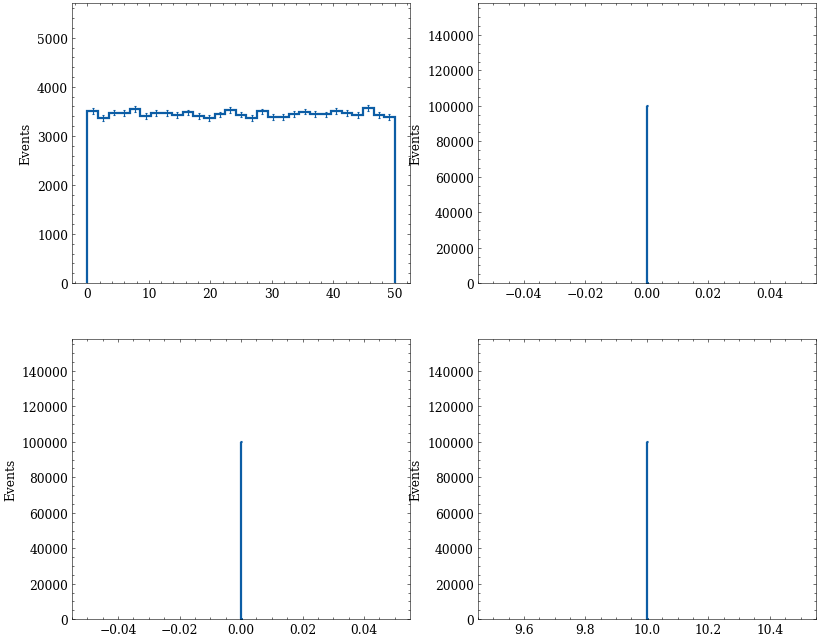

In [248]:
fig, axs = study.get_figax(4)
for i, kin in enumerate(kinematics):
    hist_multi([ getattr(event, kin) ], figax=(fig, axs.flat[i]))

In [249]:
from utils.genprodUtils import ak_rand_like

def random_two_body_decay(p4):
    s1 = ak_rand_like(lambda n : np.random.uniform(size=n), p4)
    r1 = ak_rand_like(lambda n : np.random.uniform(size=n), p4)
    r2 = s1 * (1 - r1)
    r1 = s1 * r1

    return two_body_decay(p4, r1 * p4.m, r2 * p4.m)

In [250]:
from utils.genprodUtils import hadronization
genparts = hadronization(event, maxiters=30)

Hadronization: 100%|██████████| 30/30 [02:12<00:00,  4.42s/it]


In [251]:
def get_cluster_frac(genparts):
    seed_part = ak.firsts(genparts[ak.argmax(genparts.E, axis=1, keepdims=True)])
    seed_dr = genparts.deltaR(seed_part)

    genparts_E = genparts.E
    total_E = ak.sum(genparts_E, axis=1)

    frac = dict(
        ak4 =  ak.sum(genparts_E * (seed_dr < 0.4), axis=1) / total_E,
        ak5 =  ak.sum(genparts_E * (seed_dr < 0.5), axis=1) / total_E,
        ak6 =  ak.sum(genparts_E * (seed_dr < 0.6), axis=1) / total_E,
        ak7 =  ak.sum(genparts_E * (seed_dr < 0.7), axis=1) / total_E,
        ak8 =  ak.sum(genparts_E * (seed_dr < 0.8), axis=1) / total_E,
        ak10 = ak.sum(genparts_E * (seed_dr < 1.0), axis=1) / total_E,
        ak12 = ak.sum(genparts_E * (seed_dr < 1.2), axis=1) / total_E,
        ak15 = ak.sum(genparts_E * (seed_dr < 1.5), axis=1) / total_E,
    )

    hist_multi(list(frac.values()), h_label=list(frac.keys()), h_label_stat='mean', legend=True)

    return ak.zip(frac)

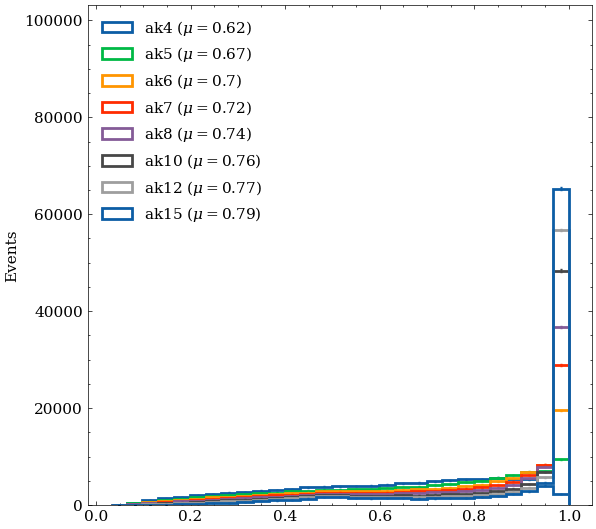

In [252]:
ak_frac = get_cluster_frac(genparts)

((<Figure size 650x650 with 1 Axes>, <AxesSubplot:>),
 <utils.plotUtils.graph.Graph at 0x7fedae428a00>)

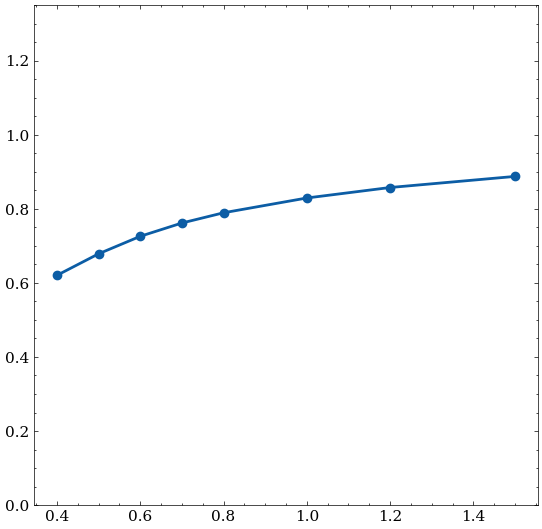

In [253]:
k = [0.4,0.5,0.6,0.7,0.8,1.0,1.2,1.5]
f = [ ak.mean(ak_frac[field]) for field in ak_frac.fields ]

graph_array(k, f)

(<Figure size 650x650 with 1 Axes>,
 <AxesSubplot:ylabel='Events'>,
 <utils.plotUtils.histogram.Histo at 0x7fed9180f4c0>)

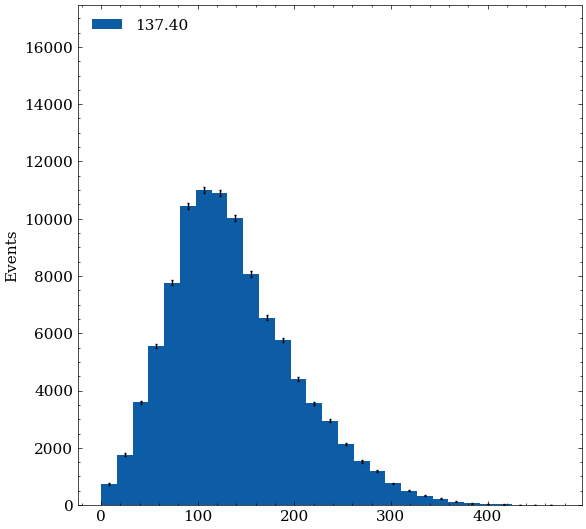

In [269]:
histo_array( ak.num(genparts), h_rebin=30, h_label_stat='{stats.mean:0.2f}', legend=True)

(<Figure size 650x650 with 2 Axes>, <AxesSubplot:>)

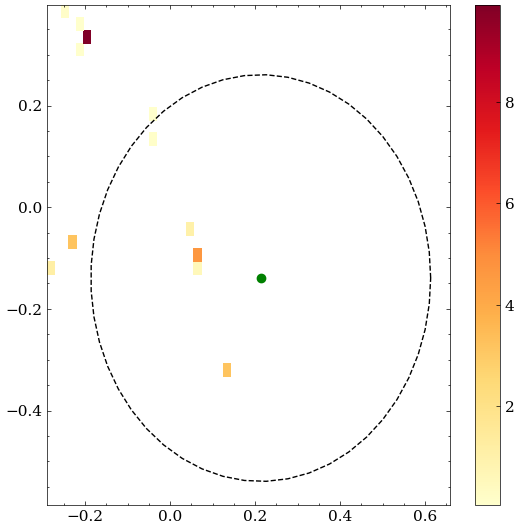

In [324]:
display = genparts[0]

def show_ak4(histo2d, ax, **kwargs):
    seed_index = np.argmax(histo2d.weights)
    seed_eta, seed_phi = histo2d.x_array[seed_index], histo2d.y_array[seed_index]
    ax.plot([seed_eta], [seed_phi], marker='o', color='green')
    ax.plot( 0.4*np.cos(np.linspace(0, 2 * np.pi)) + seed_eta, 0.4*np.sin(np.linspace(0, 2 * np.pi)) + seed_phi, color='black', linestyle='--')



histo2d_array(
    display.eta, display.phi, weights=display.E,
    colorbar=True,
    # xlim=(-1,1), ylim=(-1,1),
    exe=[
        show_ak4,
    ]
)

(<Figure size 650x650 with 1 Axes>, <AxesSubplot:>)

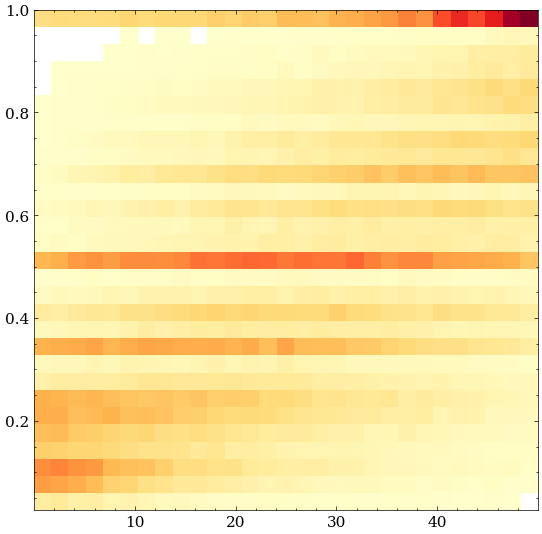

In [214]:
histo2d_array(
    event.pt, ak_frac.ak4_frac,
)